In [108]:
packages <- c("survRM2", "mvtnorm", "ggplot2", "MASS", "tidyr", "survival", "nph",
              "foreach", "doParallel", "cowplot", "IRdisplay", "rlang", "simtrial","tidyverse")

install_and_load <- function(package) {
  if (!require(package, character.only = TRUE)) {
    install.packages(package)
    library(package, character.only = TRUE)
  }
}

invisible(lapply(packages, install_and_load))

n_cores <- detectCores()
cluster <- makeCluster(16)  
registerDoParallel(cluster)
# multi thread
invisible(clusterEvalQ(cluster, #import packages to parallel 
  {
  library('survRM2')
  library('mvtnorm')
  library('cubature')
  library('survival')
  library('nph')
  library("simtrial")
  library("foreach")
  }))

source('/home/r27user6/RMST_Code/Rfiles/3m_comparison.R')
source('/home/r27user6/RMST_Code/Rfiles/Function.R')
source('/home/r27user6/RMST_Code/Rfiles/get_opt_des.R')

# NPH Early Difference

## We added a Interim Period Under Non Proportional Hazard
####  $\textcolor{yellow}{H_0 : \lambda_0 = \lambda_1 = 1.2}$    
####  $\textcolor{yellow}{H_1 : \lambda_0 = 1.2,\ \lambda_1 = Piecewise\ Exponential}$
#### HR1 is the hazard ratio before the change_time and HR2 is after
#### $HR1 = 0.67, HR2 = 1$

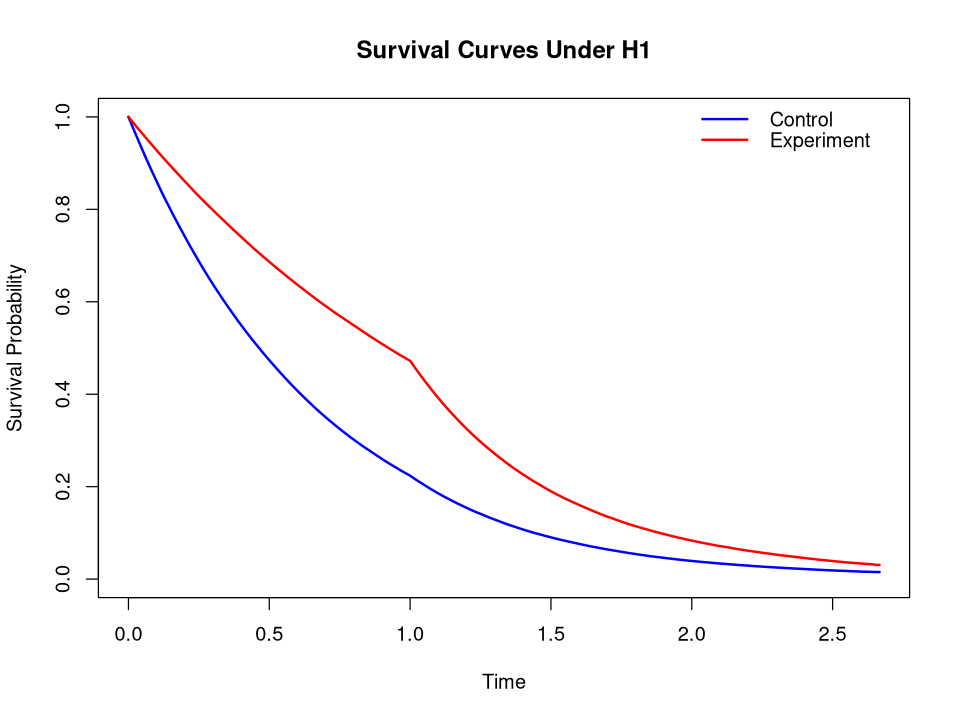

In [10]:
lambda_H0 <- 1.5
HR1 <- 0.5
HR2 <- 1
sim_size <- 10000 
N <- 100
n <- ceiling(N / 2) 
r <- 60  # patient recruit rate
acc_time <- N / r
cen_time <- 1
interim <- 120 / r
change_time <- acc_time * 0.6  # The time point between HR1 and HR2
set.seed(2024)

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0,
                         dist = 'exp', cen_time = cen_time, arm = 0, interim = interim)
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, 
                         dist = 'exp', cen_time = cen_time, arm = 1, interim = interim)                         
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, 
                          dist = 'pcw_exp', cen_time = cen_time,HR1 = HR1, HR2 = HR2, 
                          change_time = change_time, arm = 1, interim = interim)

pre_data <- rbind(data_C[ , c(4,5,1)], data_E_H1[ , c(4,5,1)])
fit <- survfit(Surv(pre_data[,1], pre_data[,2]) ~ pre_data[,3])

options(repr.plot.width = 8, repr.plot.height = 6)
plot(fit, col = c("blue", "red"), lwd = 2, xlab = "Time", ylab = "Survival Probability", main = "Survival Curves Under H1")
legend("topright", legend = c("Control", "Experiment"), col = c("blue", "red"), lwd = 2, bty = "n")


## 1.  Different Hazard Ratio (HR1)
#### $H0: \lambda_E = \lambda_C = 1.2$ is fixed.
#### $H1: \lambda_C = 1.2,\ \lambda_{E1} = 1.2*HR1$, where $\lambda_{E1}$ is the hazard of period 1. 
#### Fix HR2, Change HR1

In [31]:
lambda_H0 <- 1.2
HR2 <- 1
sim_size <- 5000 
n <- ceiling(200 / 2) 
r <- 90    # patient recruit rate
acc_time <- 200 / r
cen_time <- 1
interim <- 120 / r
change_time <- acc_time * 0.6  # The time point between HR1 and HR2
set.seed(2024)

alpha <- 0.05

HR1 <- 0.6

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                            cen_time = cen_time, arm = 0, interim = interim)    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                            cen_time = cen_time, arm = 1, interim = interim) 
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, 
                            dist = 'pcw_exp', cen_time = cen_time, HR1 = HR1, HR2 = HR2, 
                            change_time = change_time, arm = 1, interim = interim)

tau_f <- acc_time + cen_time
rmst_h0_int <- RMST_sim_cal(n = n,data_E = data_E_H0[ , c(2,3,1)], 
                                data_C = data_C[ , c(2,3,1)],tau = interim, sim_size = sim_size)
rmst_h1_int <- RMST_sim_cal(n = n,data_E = data_E_H1[ , c(2,3,1)], 
                                data_C = data_C[ , c(2,3,1)],tau = interim, sim_size = sim_size)
rmst_h0_fin <- RMST_sim_cal(n = n,data_E = data_E_H0[ , c(4,5,1)], 
                                data_C = data_C[ , c(4,5,1)],tau = tau_f, sim_size = sim_size)
rmst_h1_fin <- RMST_sim_cal(n = n,data_E = data_E_H1[ , c(4,5,1)], 
                                data_C = data_C[ , c(4,5,1)],tau = tau_f, sim_size = sim_size)
rmst_data <- rbind(rmst_h0_int, rmst_h1_int, rmst_h0_fin, rmst_h1_fin)
mu_cov_h0 <- mu_cov_mc(rmst_int = rmst_h0_int, rmst_fin = rmst_h0_fin, sim_size = sim_size)
mu_cov_h1 <- mu_cov_mc(rmst_int = rmst_h1_int, rmst_fin = rmst_h1_fin, sim_size = sim_size)     

best_our <- adp_grid_src(rmst_data = rmst_data, mu_cov_h0 = mu_cov_h0, 
                        mu_cov_h1 = mu_cov_h1, int_n = interim * r, fin_n = 2 * n, 
                        alpha = alpha, power = 0.85, sim_size = sim_size, method = 'Complex')

best_rmst <- adp_grid_src(rmst_data = rmst_data, mu_cov_h0 = mu_cov_h0, 
                        mu_cov_h1 = mu_cov_h1, int_n = interim * r, fin_n = 2 * n, 
                        alpha = alpha,power = 0.85, sim_size = sim_size, method = 'Simple')

# result_list <- list(PET0 = c(best_lr$PET0, best_rmst$PET0, best_our$PET0),
#             PET1 = c(best_lr$PET1, best_rmst$PET1, best_our$PET1),
#             alpha = c(best_lr$alpha, best_rmst$alpha, best_our$alpha),
#             power = c(best_lr$power, best_rmst$power, best_our$power))
# best_rmst
best_rmst[which(best_rmst$EN0 == min(best_rmst$EN0, na.rm = TRUE)), ]
best_our <- best_our[ which(best_our[, 'q2'] == max(best_our[, 'q2'])), ]
best_our[which(best_our$EN0 == min(best_our$EN0, na.rm = TRUE)), ]


# diff_hr1_ED <- foreach(HR1 = seq(0.5, 0.9, by = 0.05), .combine = rbind) %dopar%
#     {
#         result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
#                 interim = interim, lambda_H0 = lambda_H0, H1_type = 'NPH', 
#                 HR1 = HR1, HR2 = HR2, change_time = change_time, alpha = alpha)        
#         c(HR1, result$alpha, result$power, result$PET0, result$PET1)      
#     }


,m1,m2,q1,q2,gamma,PET0,PET1,alpha,power,PET,EN0,EN1,EN
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5282,0.01477036,0.1696017,-Inf,-Inf,0,0.5598,0.0514,0.0482,0.8616,0.3056,155.216,195.888,175.552


,m1,m2,q1,q2,gamma,PET0,PET1,alpha,power,PET,EN0,EN1,EN
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
23,-0.008369792,-0.08887882,0.6359807,0.9212314,0.015,0.6204,0.0336,0.0476,0.9578,0.327,150.368,197.312,173.84


In [6]:
load('/home/r27user6/RMST_Code/RData/diff_hr1_ED.RData')
diff_hr1_ED[1,]

[1] 0.5000 0.0496 0.0492 0.0486 0.9720 0.9800 0.7806 0.4768 0.4578 0.9496
[11] 0.0062 0.0056 0.2194 0.5000 0.0496 0.0492 0.0486 0.9720 0.9800 0.7806
[21] 0.4768 0.4578 0.9496 0.0062 0.0056 0.2194 0.5000 0.0496 0.0492 0.0486
[31] 0.9720 0.9800 0.7806 0.4768 0.4578 0.9496 0.0062 0.0056 0.2194 0.5000
[41] 0.0496 0.0492 0.0486 0.9720 0.9800 0.7806 0.4768 0.4578 0.9496 0.0062
[51] 0.0056 0.2194 0.5000

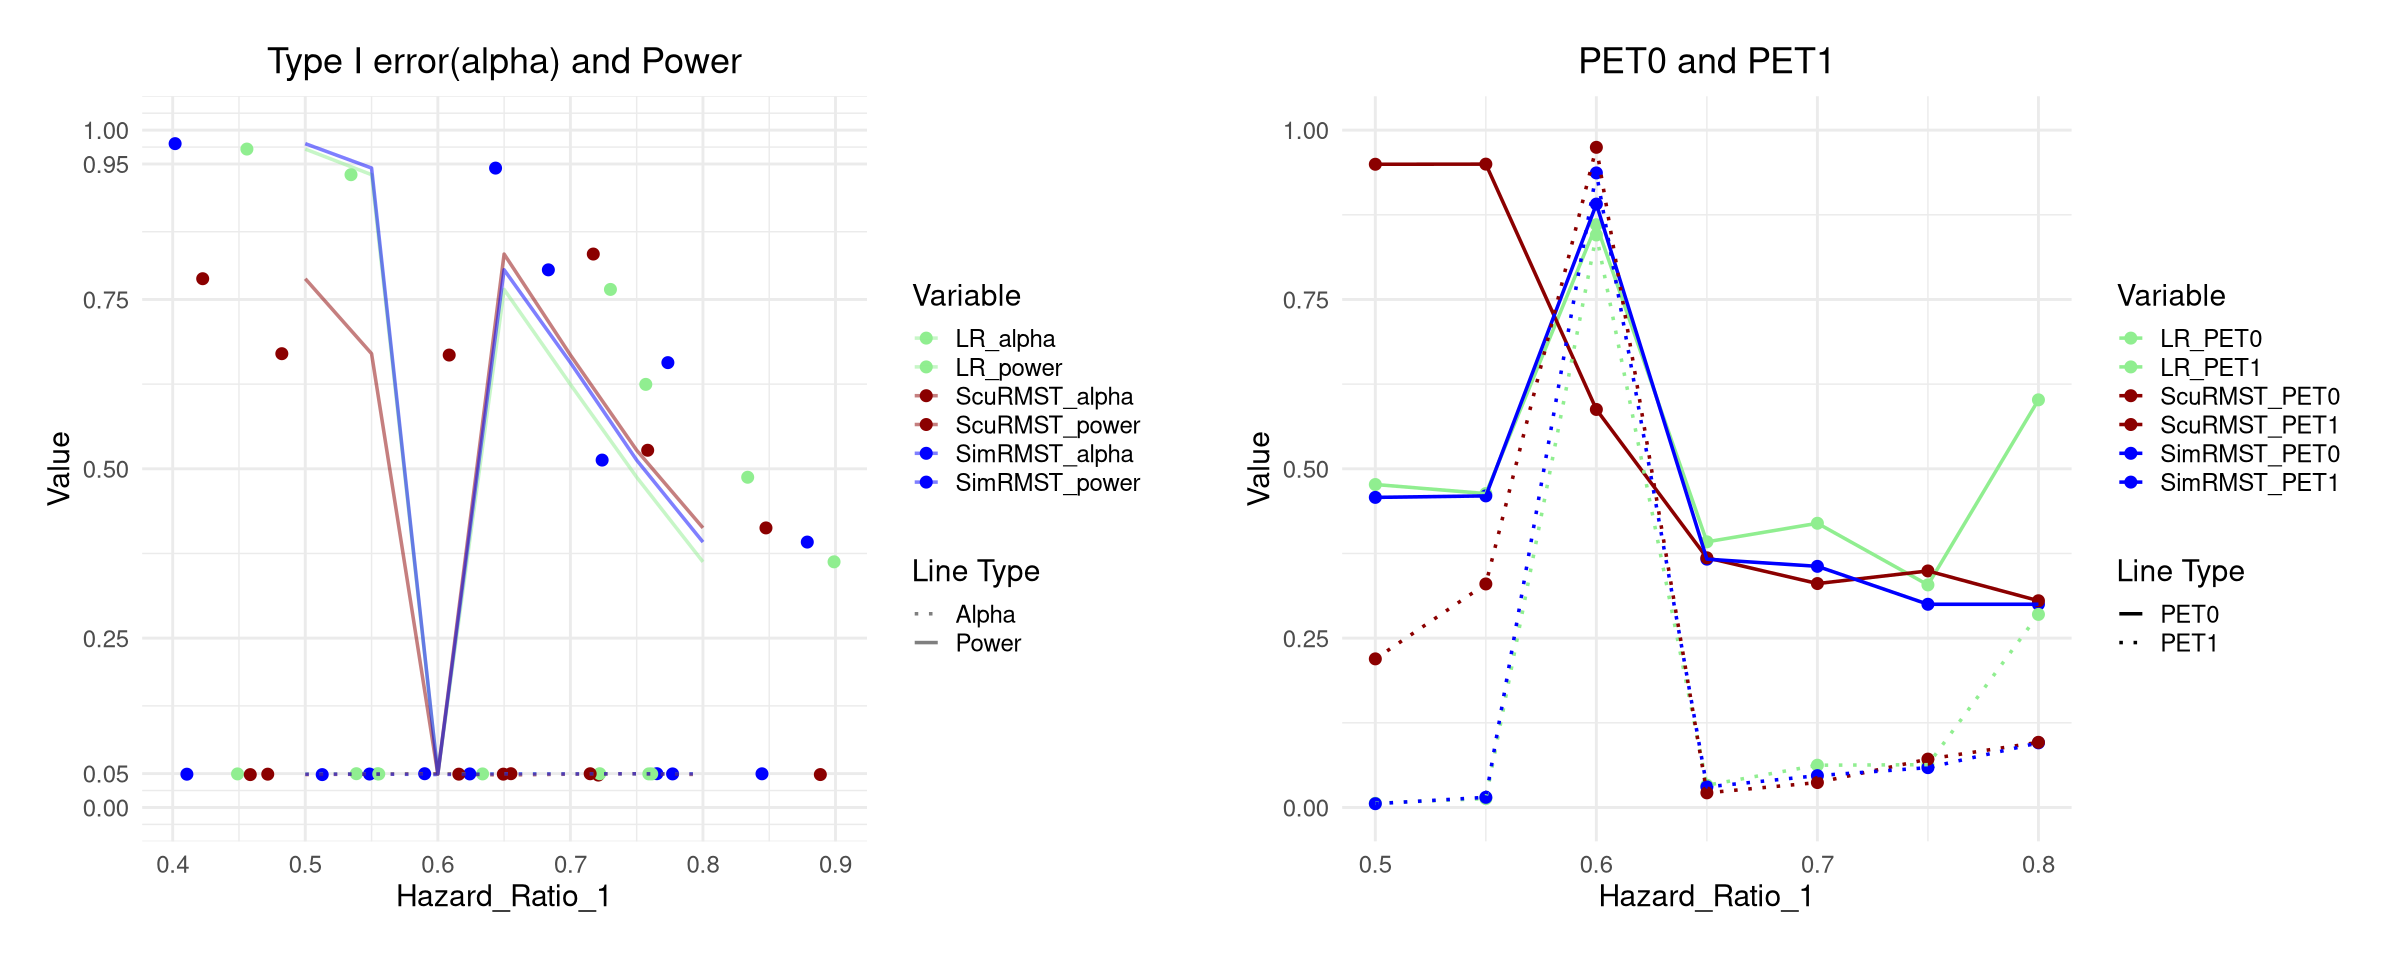

In [4]:
save(diff_hr1_ED, file = '/home/r27user6/RMST_Code/RData/diff_hr1_ED.RData')
#load('/home/r27user6/RMST_Code/RData/diff_hr1_ED.RData')
# self-define function for drawing plots
p1 <- compare_line_plot(data = diff_hr1_ED[1:7,], var_name = 'Hazard_Ratio_1')
p1


## 2. Different interim period

In [22]:
set.seed(2024)
lambda_H0 <- 1.5
HR1 <- 0.5
HR2 <- 1
N <- 150
sim_size <- 6000 
n <- ceiling(N / 2) 
r <- 100  # patient recruit rate
acc_time <- N / r
cen_time <- 1
change_time <- 0.6 # The time point between HR1 and HR2
alpha <- 0.05

diff_interim_ED <- c()
for (int_sam in seq(0.4, 0.8, by = 0.05))
    {
        interim <- int_sam * acc_time
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, H1_type = 'NPH', tau = 2.5,
                HR1 = HR1, HR2 = HR2, change_time = change_time, alpha = alpha)        
        diff_interim_ED <- rbind(diff_interim_ED,
                            c(interim*r, result$alpha, result$power, result$PET0, result$PET1))     
    }
save(diff_interim_ED, file = '/home/r27user6/RMST_Code/RData/diff_interim_ED.RData')

In [23]:
lambda_H0 <- 1.5
HR1 <- 1
HR2 <- 0.5
sim_size <- 6000
N <- 150
r <- 100
n <- ceiling(N / 2) 
acc_time <- N/r
cen_time <- 1
change_time <- 0.6  # The time point between HR1 and HR2
alpha <- 0.05

diff_interim_LD <- c()
for(int_sam in seq(0.4, 0.8, by = 0.05))
    {
        interim <- int_sam * acc_time
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, H1_type = 'NPH', tau = 2.5,
                HR1 = HR1, HR2 = HR2, change_time = change_time, alpha = alpha)        
        diff_interim_LD <- rbind(diff_interim_LD,
                            c(int_sam * N, result$alpha, result$power, result$PET0, result$PET1))      
    }
save(diff_interim_LD, file = '/home/r27user6/RMST_Code/RData/diff_interim_LD.RData')


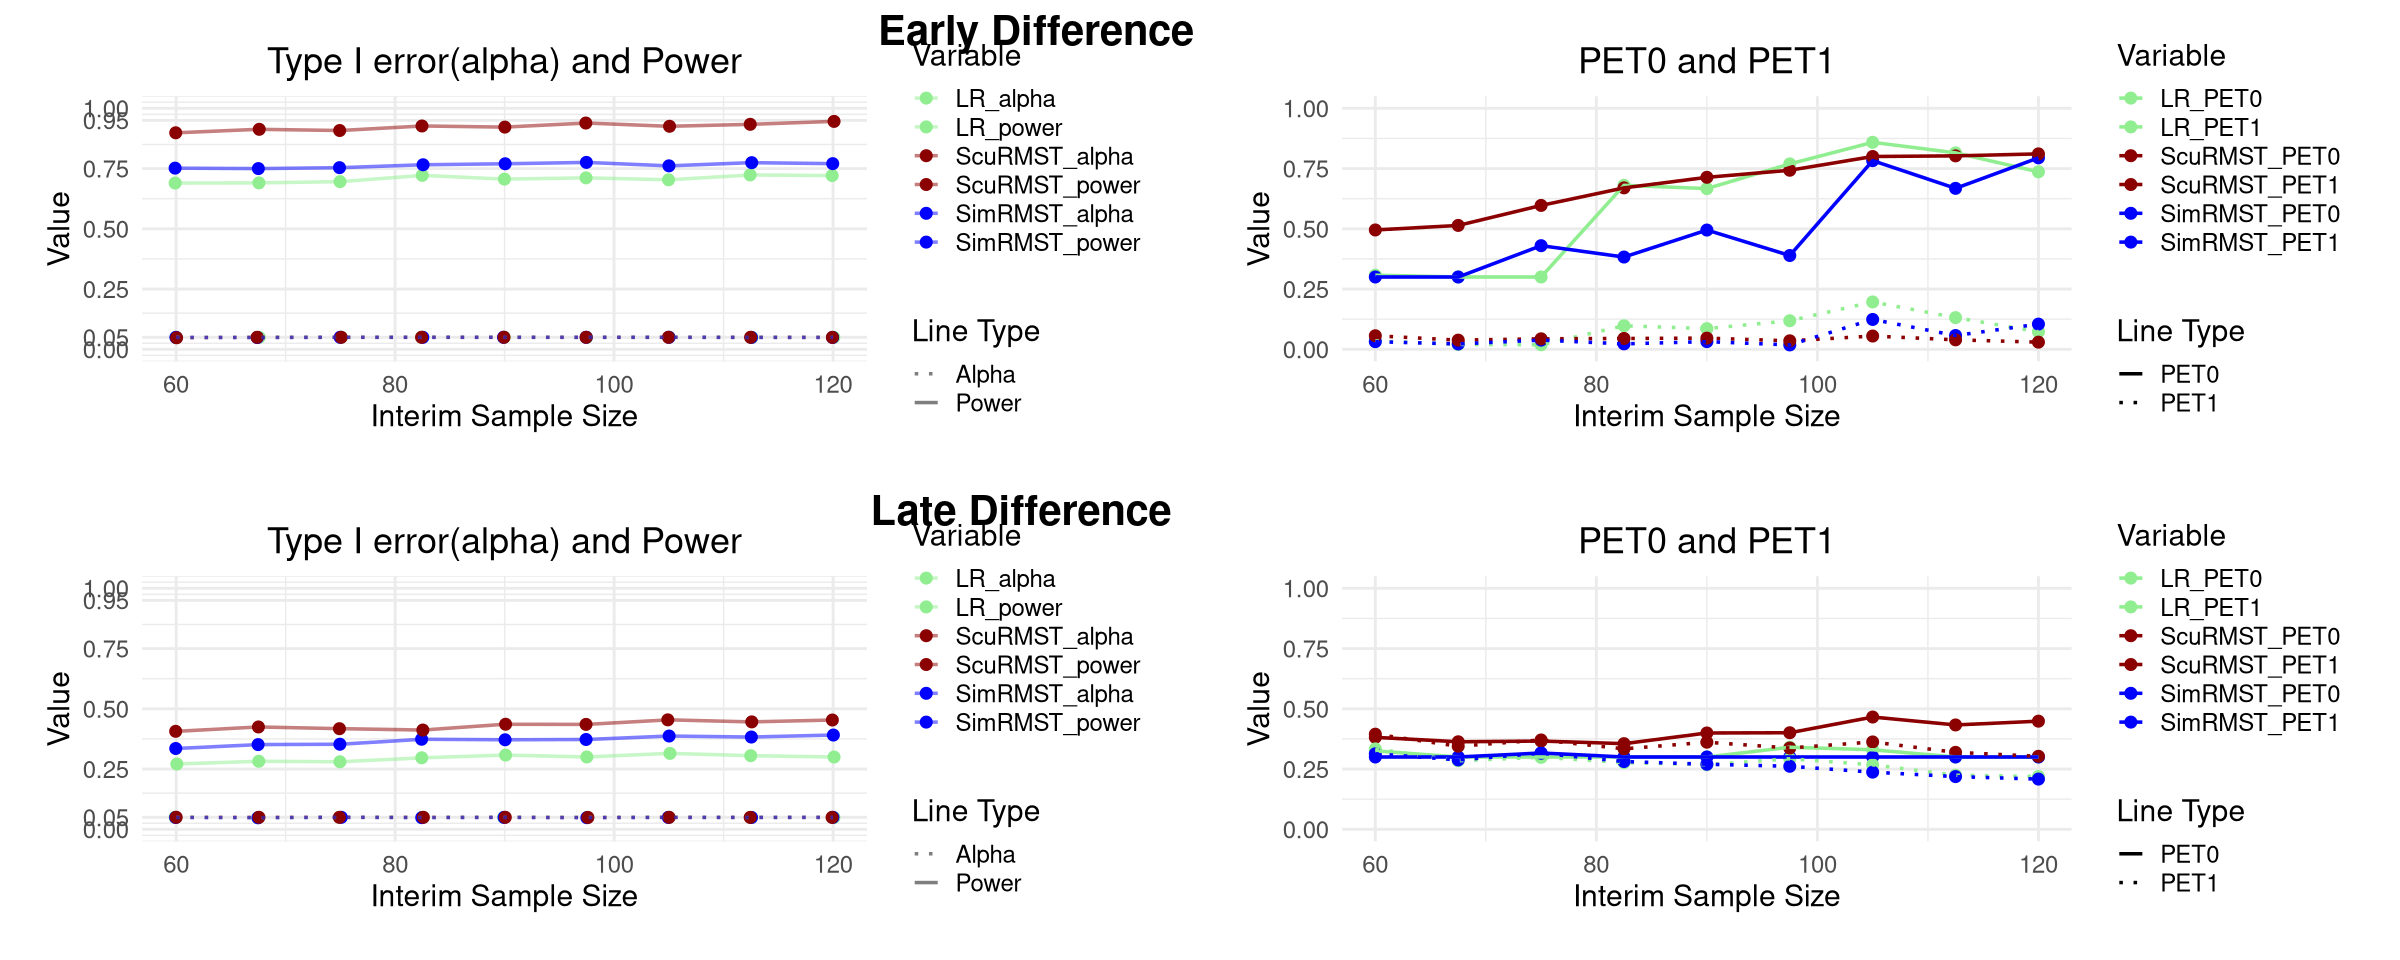

In [3]:
load('/home/r27user6/RMST_Code/RData/diff_interim_ED.RData')
load('/home/r27user6/RMST_Code/RData/diff_interim_LD.RData')
p2_late_diff <- compare_line_plot(data = diff_interim_LD, var_name = 'Interim Sample Size')
p2_early_diff <- compare_line_plot(data = diff_interim_ED, var_name = 'Interim Sample Size')
p <- plot_grid(p2_early_diff, p2_late_diff, labels = c("Early Difference", "Late Difference"), 
            label_x = c(0.3, 0.3), label_size = 25, ncol = 1)
p
ggsave("/home/r27user6/RMST_Code/figures/Comparison/early_late_diff_itrm.jpg", 
        plot = p,width = 20, height = 15, dpi = 300)


In [4]:
diff_interim_LD

60.0,0.04983333,0.04900000,0.04983333,0.2708333,0.3353333,0.4065000,0.3253333,0.3000000,0.3815000,0.3336667,0.3133333,0.3946667
67.5,0.04816667,0.04783333,0.04983333,0.2823333,0.3515000,0.4246667,0.3000000,0.3000000,0.3631667,0.2843333,0.2880000,0.3446667
75.0,0.04900000,0.04983333,0.04966667,0.2801667,0.3530000,0.4175000,0.3000000,0.3166667,0.3661667,0.2988333,0.3156667,0.3706667
82.5,0.04916667,0.04833333,0.04983333,0.2966667,0.3736667,0.4118333,0.3000000,0.3000000,0.3553333,0.2768333,0.2811667,0.3338333
90.0,0.04966667,0.04933333,0.04966667,0.3080000,0.3715000,0.4358333,0.3000000,0.3000000,0.3996667,0.2678333,0.2700000,0.3613333
97.5,0.04983333,0.04816667,0.04916667,0.3001667,0.3726667,0.4353333,0.3405000,0.3000000,0.4006667,0.2926667,0.2615000,0.3373333
105.0,0.04966667,0.04933333,0.04966667,0.3150000,0.3870000,0.4541667,0.3300000,0.3000000,0.4658333,0.2676667,0.2371667,0.3625000
112.5,0.04883333,0.04916667,0.04950000,0.3055000,0.3828333,0.4456667,0.3000000,0.3000000,0.4330000,0.2245000,0.2186667,0.3193333
120.0,0.04900000,0.04966667,0.04950000,0.3000000,0.3911667,0.4535000,0.3000000,0.3000000,0.4486667,0.2190000,0.2083333,0.3028333


------
## 3. Different Recruit Rate
### Constant recruit rate. Smaller value means longer accrual time and interim period

In [7]:
lambda_H0 <- 1.2
HR1 <- 0.67
HR2 <- 1
sim_size <- 10000 
n <- ceiling(200 / 2) 
cen_time <- 1
change_time <- acc_time * 0.5  # The time point between HR1 and HR2
set.seed(2024)

alpha <- 0.05

diff_rec_rate_ED <- foreach(r = seq(40, 130, by = 10), .combine = rbind) %dopar%
    {
        acc_time <- 200 / r
        interim <- 120 / r 
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, H1_type = 'NPH', 
                HR1 = HR1, HR2 = HR2, change_time = change_time, alpha = alpha)        
        c(r, result$alpha, result$power, result$PET0, result$PET1)  
    }

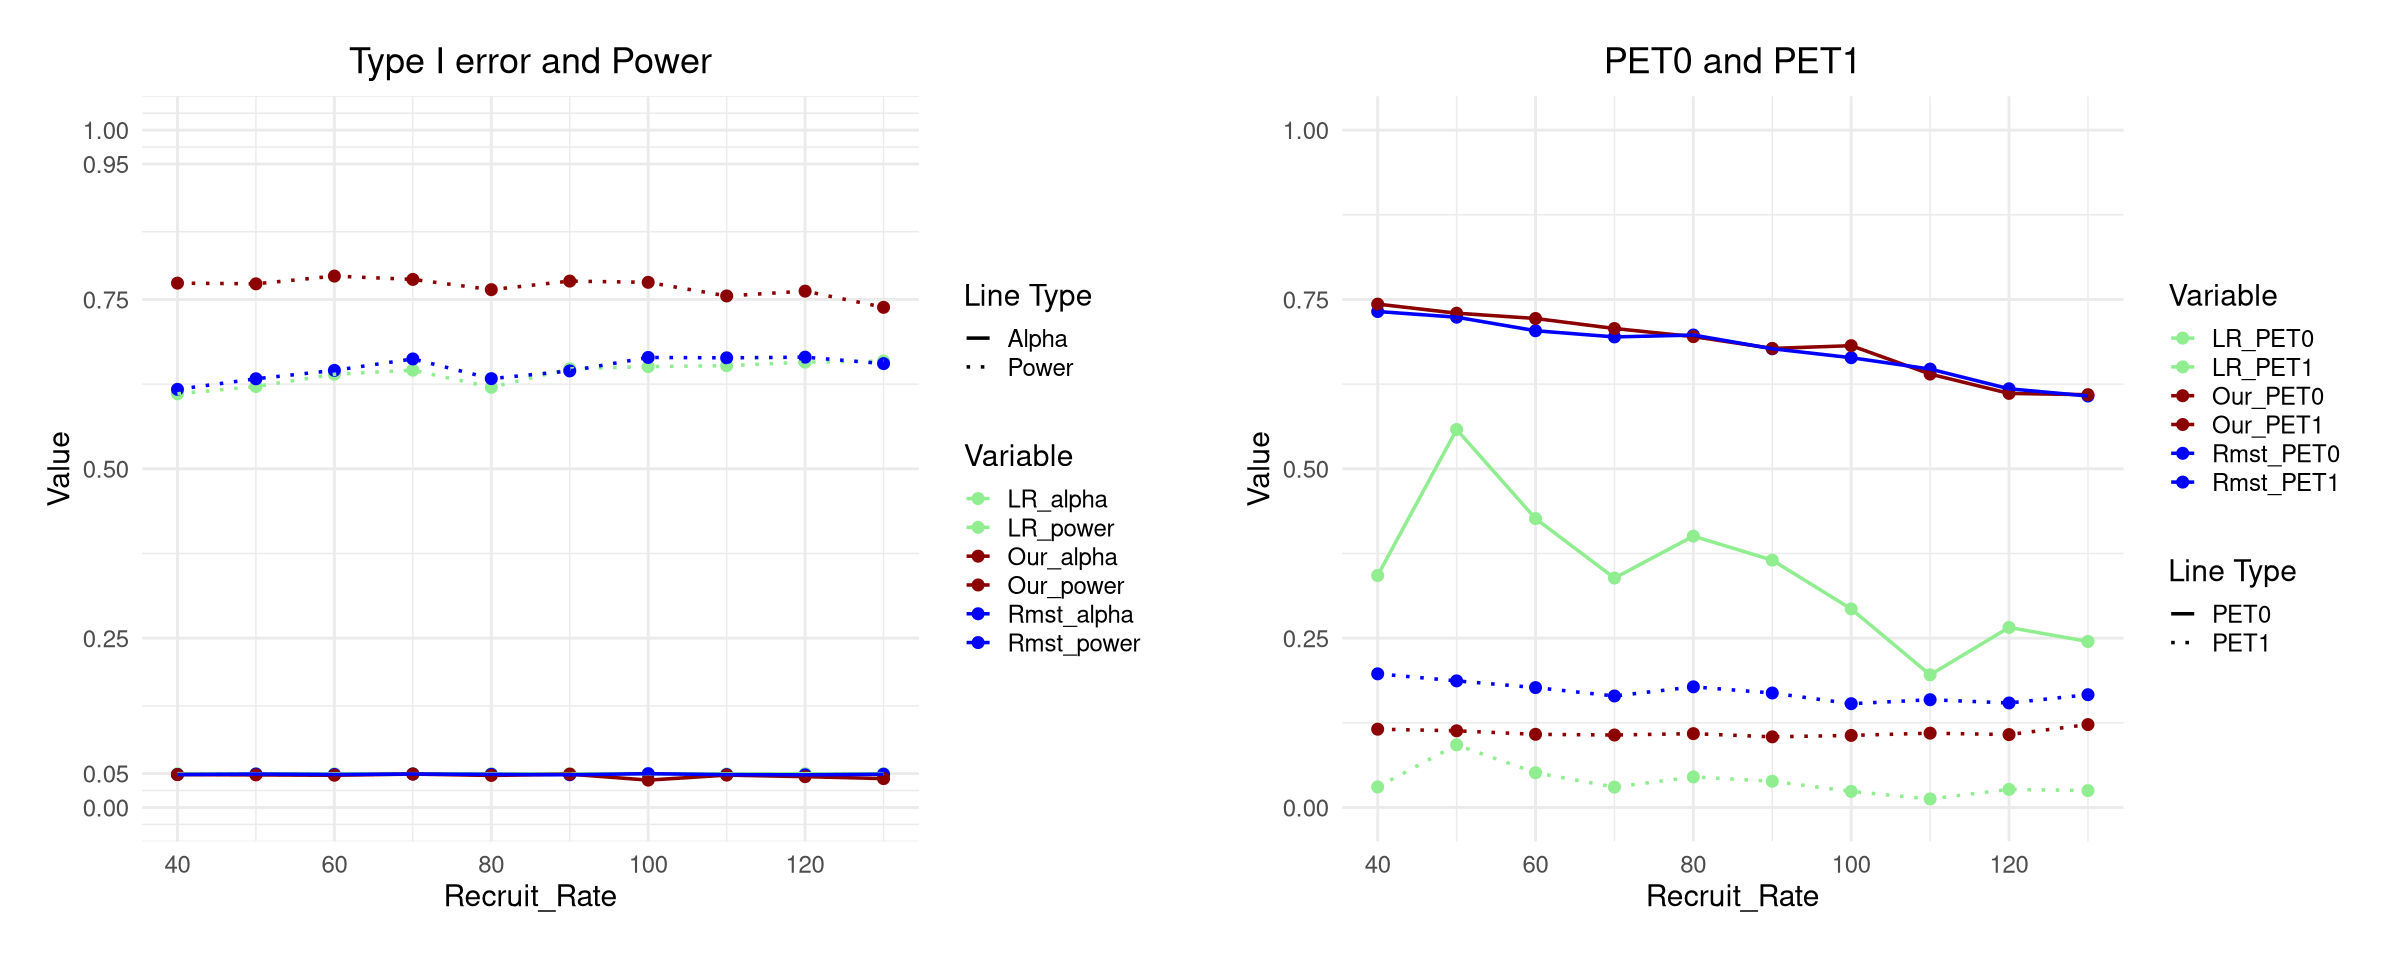

In [16]:
save(diff_rec_rate_ED, file = '/home/r27user6/RMST_Code/RData/diff_rec_rate_ED.RData')
load('/home/r27user6/RMST_Code/RData/diff_rec_rate_ED.RData')

p3 <- compare_line_plot(data = diff_rec_rate_ED, var_name = 'Recruit_Rate')
p3

------
## 4. Different Changing Point
#### The time point of HR1 to HR2

In [9]:
lambda_H0 <- 1.2
HR1 <- 0.67
HR2 <- 1
sim_size <- 10000 
n <- ceiling(200 / 2) 
r <- 90  # patient recruit rate
acc_time <- 200 / r
cen_time <- 1
interim <- 120 / r
set.seed(2024)

alpha <- 0.05

diff_ct_ED <- foreach(ct_rate = seq(0.2, 0.8, by = 0.06), .combine = rbind) %dopar%
    {
        change_time <- acc_time * ct_rate
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, H1_type = 'NPH', 
                HR1 = HR1, HR2 = HR2, change_time = change_time, alpha = alpha)        
        c(change_time, result$alpha, result$power, result$PET0, result$PET1)  
    }

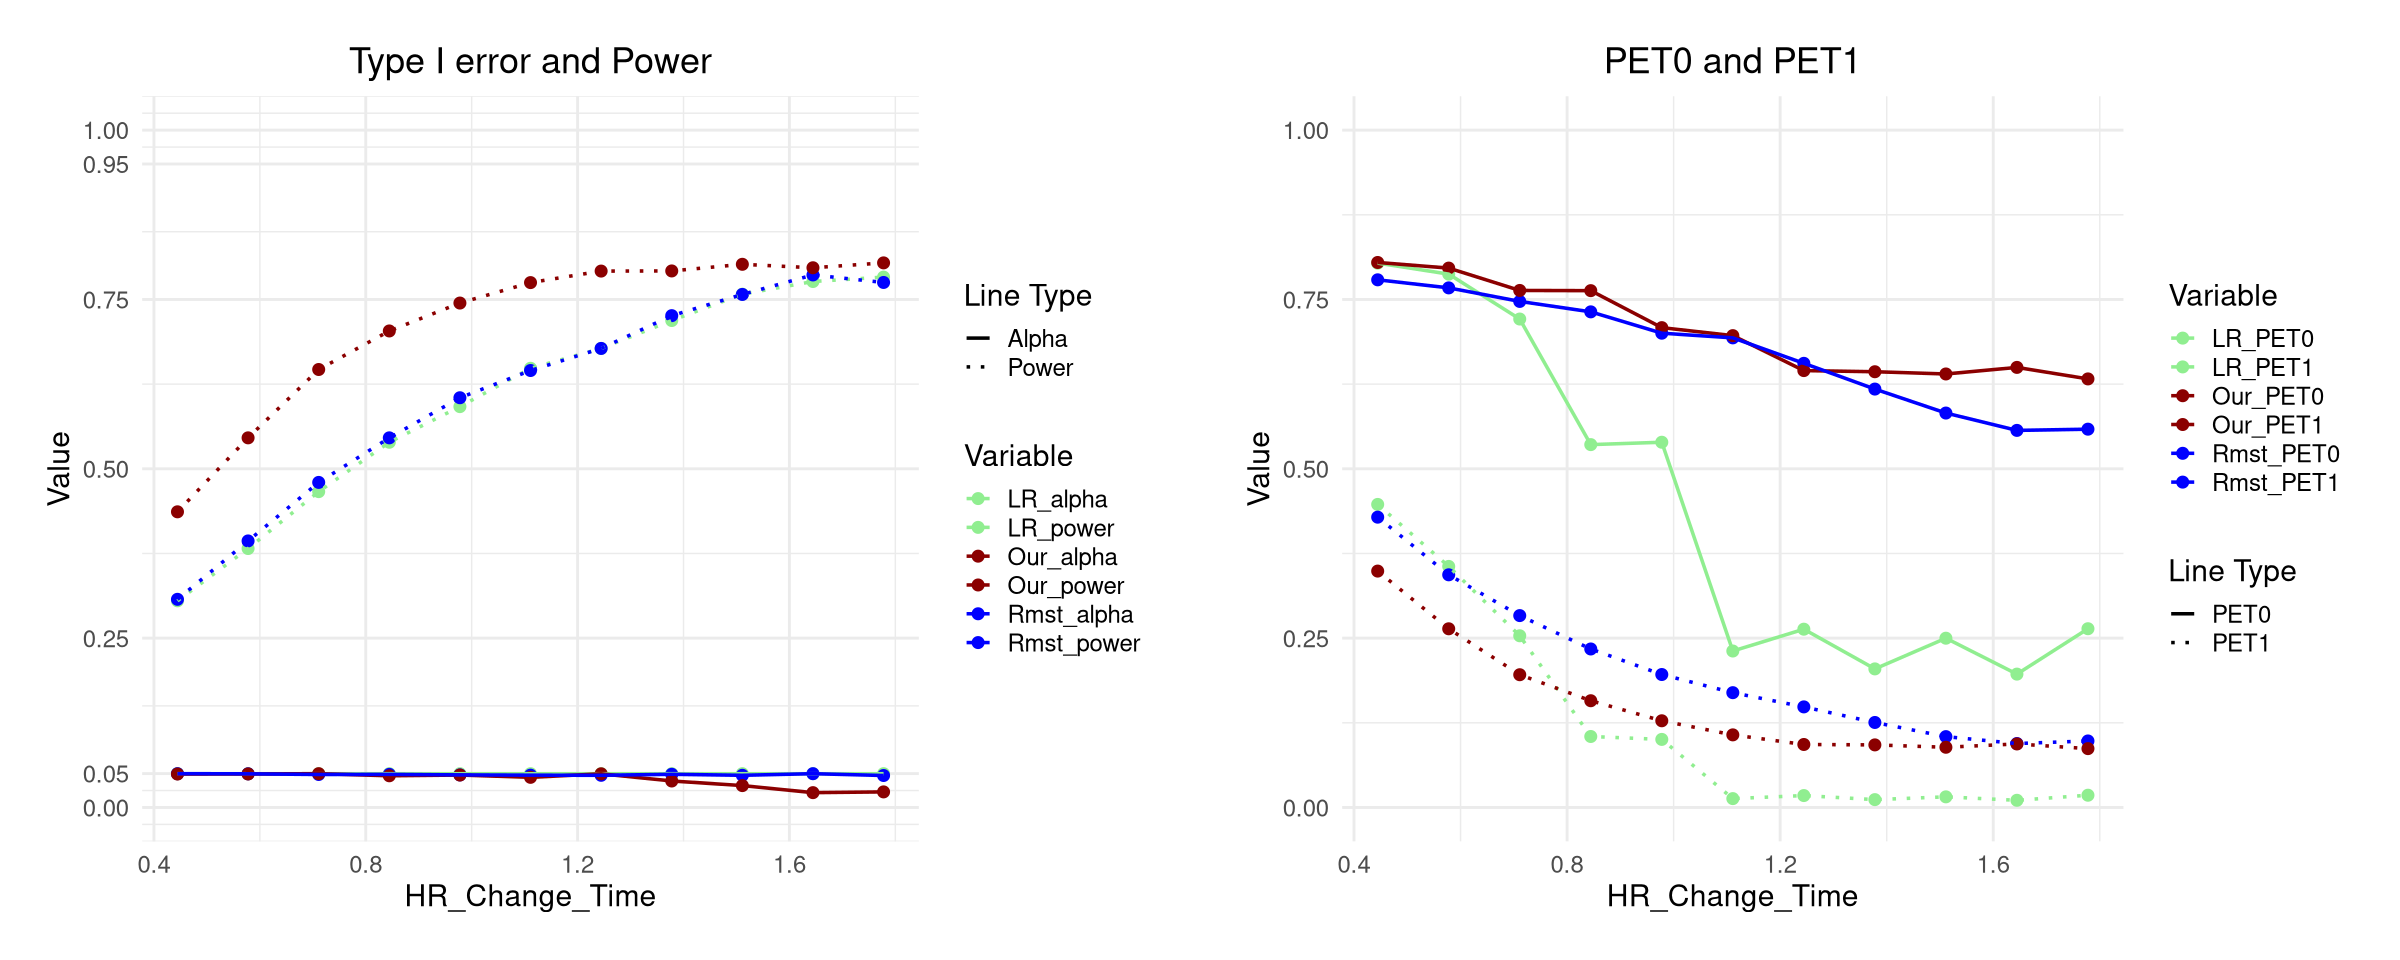

In [5]:
#save(diff_ct_ED, file = '/home/r27user6/RMST_Code/RData/diff_ct_ED.RData')
load('/home/r27user6/RMST_Code/RData/diff_ct_ED.RData')

p4 <- compare_line_plot(data = diff_ct_ED, var_name = 'HR_Change_Time')
p4

-----
## 5. Different Follow Up Time : censoring distribution
### Censoring distribution $C \sim U [b , a + b]$, where b is the follow up time.
### We tune b from 0.6 to 1.6

In [11]:
lambda_H0 <- 1.2
HR1 <- 0.67
HR2 <- 1
sim_size <- 10000 
n <- ceiling(200 / 2) 
r <- 90    # patient recruit rate
acc_time <- 200 / r
interim <- 120 / r
change_time <- acc_time * 0.5  # The time point between HR1 and HR2
set.seed(2024)

alpha <- 0.05

diff_cen_ED <- foreach(cen_time = seq(0.6, 1.5, by = 0.1), .combine = rbind) %dopar%
    {
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, H1_type = 'NPH', 
                HR1 = HR1, HR2 = HR2, change_time = change_time, alpha = alpha)        
        c(cen_time, result$alpha, result$power, result$PET0, result$PET1)        
    }

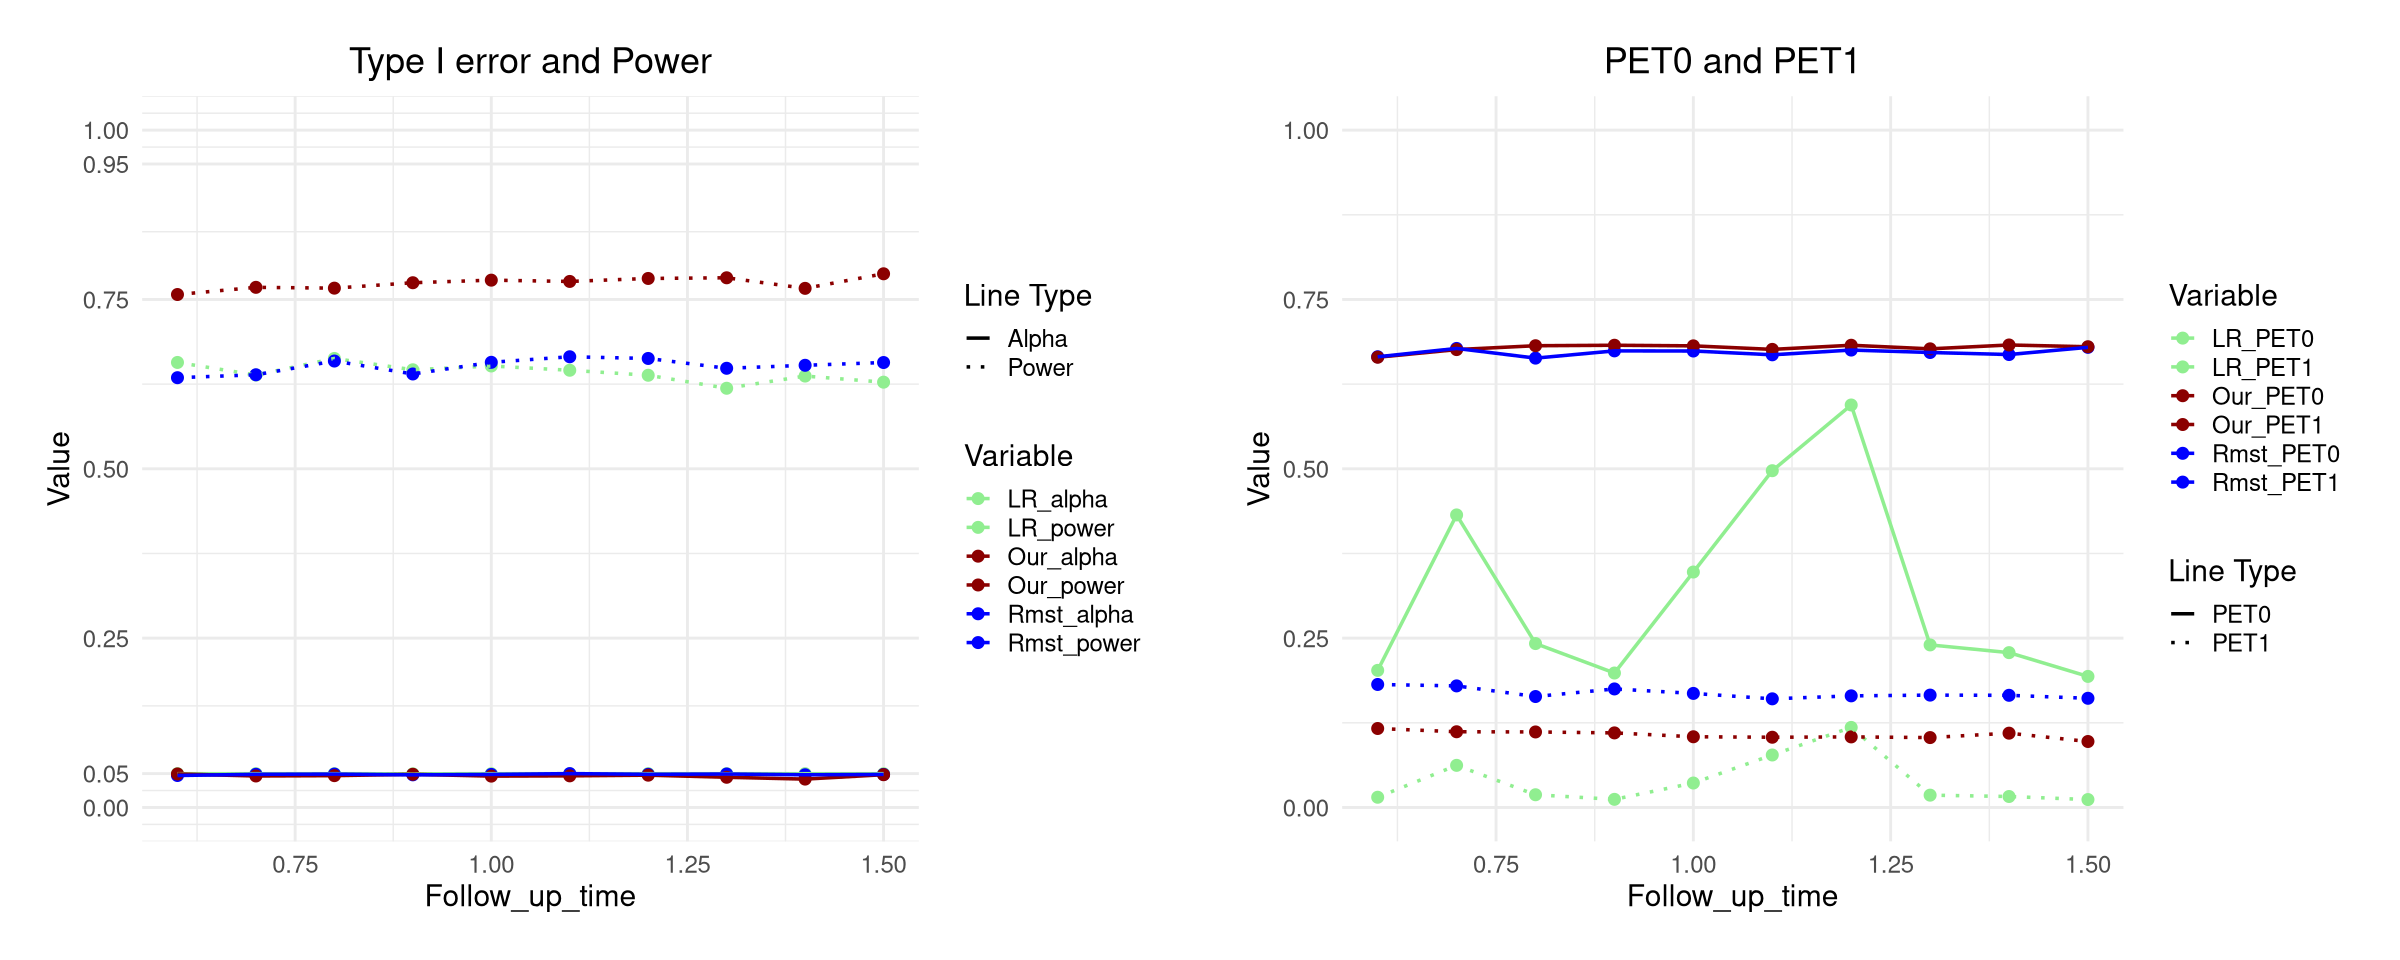

In [8]:
#save(diff_cen_ED, file = '/home/r27user6/RMST_Code/RData/diff_cen_ED.RData')
load('/home/r27user6/RMST_Code/RData/diff_cen_ED.RData')

p5 <- compare_line_plot(data = diff_cen_ED, var_name = 'Follow_up_time')
p5

-----
# Optimal design

### Set a minimal $N_0$ (Single stage RMST sample size can be used as reference)
### For every $N_i > N_0$ find the $min E_{N_i}(n_j)$, where $n_j$ is the interim sample size
### Then find the $min E_{N_i}$ for all $N_i$
### Use the same setting as above
#### 1. Calculate the single stage RMST sample size under ($\alpha = 0.05, power = 0.8$)

In [ ]:
lambda_H0 <- 1.5
HR1 <- 0.5
HR2 <- 1
N <- 200
sim_size <- 5000 
n <- ceiling(N / 2) 
r <- 90  # patient recruit rate
acc_time <- N / r
cen_time <- 1
change_time <- 0.6 # The time point between HR1 and HR2
interim <- 0.7
alpha <- 0.05

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time,arm = 0, interim = interim) 
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, 
                            dist = 'pcw_exp', cen_time = cen_time, HR1 = HR1, HR2 = HR2, 
                            change_time = change_time, arm = 1, interim = interim)
# power of one sided log rank test
log_rank_1 <- log_rank_sim(data_C = data_C[ , c(4,5,1)] , data_E = data_E_H1[ , c(4,5,1)] 
                            ,sim_size = sim_size, n = n, alpha = alpha ,sided = 'greater')
log_rank_1$rejection

# power of one sided RMST difference test
simple_rmst_1 <- RMST_sim_test(data_C = data_C[ , c(4,5,1)] , data_E = data_E_H1[ , c(4,5,1)]
                            ,sim_size = sim_size, tau = 2.5, n = n
                            ,alpha = alpha ,sided = 'greater')
simple_rmst_1$test_result$rejection

[1] 0.7924

[1] 0.8284

In [6]:
set.seed(2024)
lambda_H0 <- 1.5
HR1 <- 0.4
HR2 <- 1
sim_size <- 5000 
r <- 60  # patient recruit rate
cen_time <- 1
change_time <- 1 # The time point between HR1 and HR2

alpha <- 0.1
power <- 0.85

result_LR <- data.frame()
result_scu <- c()
result_sim <- c()

for (N in seq(from = 38, to = 46, 4))
{
    n <- ceiling(N / 2) 
    acc_time <- N/r
    our_rmst <-  get_opt_des(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                        int_step = 2, lambda_H0 = lambda_H0, H1_type = 'NPH', HR1 = HR1, HR2 = HR2, tau = 1.2,
                        change_time = change_time, alpha = alpha, power = power, method = 'Complex') 
    res <- our_rmst[, c('PET0','PET1','alpha','power','PET','EN0','EN1','EN','interim_n')]
    res$N <- c(N)
    res$Method <- 'scu_rmst'
    result_scu <- rbind(result_scu, res)
    saveRDS(result_scu, "tem_result_scu.rds")
}

# for (N in seq(from = 40, to = 56, 4))
# {
#     n <- ceiling(N / 2) 
#     acc_time <- N/r
#     sim_rmst <-  get_opt_des(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
#                         int_step = 2, lambda_H0 = lambda_H0, H1_type = 'NPH', HR1 = HR1, HR2 = HR2, tau = 1.2,
#                         change_time = change_time, alpha = alpha, power = power, method = 'Simple')     
#     res <- sim_rmst[, c('PET0','PET1','alpha','power','PET','EN0','EN1','EN','interim_n')]
#     res$N <- c(N)
#     res$Method <- 'sim_rmst'
#     result_sim <- rbind(result_sim, res)
#     saveRDS(result_sim, "tem_result_sim.rds")
#  }

# for (N in seq(50, 60, by = 2))
# {
#     n <- ceiling(N / 2) 
#     acc_time <- N / r 
#     lr_opt <- get_opt_des(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
#                         int_step = 2, lambda_H0 = lambda_H0, H1_type = 'NPH', HR1 = HR1, HR2 = HR2, 
#                         change_time = change_time, alpha = alpha, power = power, method = 'logrank')   
#     res <- lr_opt[, c('PET0','PET1','alpha','power','PET','EN0','EN1','EN','interim_n')]
#     res$N <- N
#     res$Method <- 'log_rank'
#     result_LR <- rbind(result_LR, res)
#     saveRDS(result_LR, "tem_result_lr.rds")
# }

# result_LR
result_sim
result_scu


NULL

PET0,PET1,alpha,power,PET,EN0,EN1,EN,interim_n,N,Method
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<dbl>,<chr>
0,0,0,0,0,NA,NA,NA,NA,38,scu_rmst
0,0,0,0,0,NA,NA,NA,NA,42,scu_rmst
0,0,0,0,0,NA,NA,NA,NA,46,scu_rmst


_________

In [149]:
set.seed(2024)
lambda_H0 <- 1.5
HR1 <- 0.4
HR2 <- 1
sim_size <- 5000 
r <- 60  # patient recruit rate
cen_time <- 1
change_time <- 1 # The time point between HR1 and HR2

alpha <- 0.1
power <- 0.85
n <- 24
acc_time <- 2 * n / r 
interim <- 0.6 * acc_time
tau_f <- 1.2
int_n = interim * r
fin_n = 2 * n

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time,arm = 0, interim = interim)    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, 
                            dist = 'pcw_exp', cen_time = cen_time, HR1 = HR1, HR2 = HR2, 
                            change_time = change_time, arm = 1, interim = interim)
                                
rmst_h0_int <- RMST_sim_cal(n = n, data_E = data_E_H0[ , c(2,3,1)], data_C = data_C[ , c(2,3,1)],
                            tau = interim,sim_size = sim_size)
rmst_h0_fin <- RMST_sim_cal(n = n, data_E = data_E_H0[ , c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = tau_f, sim_size = sim_size)                                 
rmst_h1_int <- RMST_sim_cal(n = n, data_E = data_E_H1[ , c(2,3,1)], data_C = data_C[ , c(2,3,1)],
                            tau = interim,sim_size = sim_size)
rmst_h1_fin <- RMST_sim_cal(n = n, data_E = data_E_H1[ , c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = tau_f, sim_size = sim_size)
rmst_data <- rbind(rmst_h0_int, rmst_h1_int, rmst_h0_fin, rmst_h1_fin)

# Under H0
mu_cov_h0 <- mu_cov_mc(rmst_int = rmst_h0_int, rmst_fin = rmst_h0_fin, sim_size = sim_size)
# Under H1
mu_cov_h1 <- mu_cov_mc(rmst_int = rmst_h1_int, rmst_fin = rmst_h1_fin, sim_size = sim_size)


mu1 <- mu_cov_h1$mu[c(1,2)]
      sigma1 <- mu_cov_h1$sigma[1:2, 1:2]
      # Final
      mu2 <- mu_cov_h1$mu[c(3,4)]
      sigma2 <- mu_cov_h1$sigma[3:4, 3:4]

  # cal_q <- function(m, tar_prob, mu, sigma)  # conditional normal dist
  #     {
  #       mu_D <- mu[1]
  #       mu_E <- mu[2]
  #       sigma_D <- sqrt(sigma[1, 1])
  #       sigma_E <- sqrt(sigma[2, 2])
  #       rho <- sigma[1, 2] / (sigma_D * sigma_E) #corr
  #       #truncated normal
  #       alpha <- (m - mu_D) / sigma_D  
  #       # Mean and variance of the truncated normal distribution D | D > m
  #       mean_D_given_D_gt_m <- mu_D + sigma_D * dnorm(alpha) / (1 - pnorm(alpha))
  #       var_D_given_D_gt_m <- sigma_D^2 * (1 - (alpha * dnorm(alpha) / (1 - pnorm(alpha))) - 
  #                                         (dnorm(alpha) / (1 - pnorm(alpha)))^2)
  #       # Mean of E given D > m
  #       mean_E_given_D_gt_m <- mu_E + rho * (sigma_E / sigma_D) * 
  #                             (mean_D_given_D_gt_m - mu_D)
  #       # Variance of E given D > m
  #       var_E_given_D_gt_m <- (1 - rho^2) * sigma_E^2 + 
  #                             (rho * sigma_E / sigma_D)^2 * var_D_given_D_gt_m
  #       # Calculate q such that P(E > q | D > m) = p
  #       q <- tryCatch(
  #         {
  #           qnorm(tar_prob, mean = mean_E_given_D_gt_m, sd = sqrt(var_E_given_D_gt_m), 
  #                   lower.tail = FALSE)
  #         }, error = function(e)  # sometimes when m is large, no root
  #         {
  #           return(NA)
  #         })
          
  #       return(q)
  #     }

    cal_q <- function(m, tar_prob, mu, sigma)  # conditional normal dist
      {
        q_sol <- tryCatch(
          {
            uniroot( 
              function(q) 
                {
                  prob <- pmvnorm(lower = c(m, q), upper = c(Inf, Inf), 
                                  mean = mu, sigma = sigma)
                  return(prob - tar_prob)
                }, interval = c(0, 10))$root
          }, error = function(e)  # sometimes when m is large, no root
          {
            return(NA)
          })   
        return(q_sol)
      }

  cal_proc <- function(rmst_int, rmst_fin, m1, q1, m2, q2) {
                       sum((rmst_int[2, ] - rmst_int[1, ] > m1) & (rmst_int[2, ] > q1) &
                            (rmst_fin[2, ] - rmst_fin[1, ] > m2) & (rmst_fin[2, ] > q2)) / sim_size
                      }
  cal_pet <- function(rmst_int, m1, q1){
                      sum((rmst_int[2, ] - rmst_int[1, ] < m1) | 
                          (rmst_int[2, ] < q1)) / sim_size
                      }

  ub_m1 <- quantile(rmst_h1_int[2,] - rmst_h1_int[1, ], 0.8)
  lb_m1 <- quantile(rmst_h0_int[2,] - rmst_h0_int[1, ], 0.2)
  ub_m2 <- quantile(rmst_h1_fin[2,] - rmst_h1_fin[1, ], 0.8)
  lb_m2 <- quantile(rmst_h0_fin[2,] - rmst_h0_fin[1, ], 0.8)
  m1_values <- seq(lb_m1, ub_m1, by = (ub_m1 - lb_m1) / 100) 
  m2_values <- seq(lb_m2, ub_m2, by = (ub_m2 - lb_m2) / 100)

  # crit_val_res <- foreach(lambda = seq(0.005, 0.1, by = 0.005), .combine = 'rbind') %:%
  #                foreach(gamma = seq(0.005, 0.1, by = 0.005), .combine = 'rbind') %dopar% {
  #   tar_prob_int <- exp(-lambda * (int_n / fin_n)^gamma) 
  #   tar_prob_fin <- exp(-lambda * (fin_n / fin_n)^gamma)

crit_val_res <- foreach(tar_prob_int = seq(0.8, 0.95, by = 0.01), .combine = 'rbind') %:%
                 foreach(tar_prob_fin = seq(0.8, 0.95, by = 0.01), .combine = 'rbind') %dopar% {

    lambda <- tar_prob_int
    gamma <- tar_prob_fin
    # interim
    q1_values <- sapply(m1_values, cal_q, tar_prob = tar_prob_int, mu = mu1, sigma = sigma1)
    mq1 <- data.frame(m1_values = m1_values, q1_values = q1_values)
    mq1 <- data.frame(mq1[!is.na(mq1[,2]),])
    
    # final
    q2_values <- sapply(m2_values, cal_q, tar_prob = tar_prob_fin, mu = mu2, sigma = sigma2)
    mq2 <- data.frame(m2_values = m2_values, q2_values = q2_values)
    mq2 <- data.frame(mq2[!is.na(mq2[,2]),])
    
    # for some gamma, no solution for q1 or q2
    if (nrow(mq1) == 0 | nrow(mq2) == 0) {
        return(NULL)
    }
    
    combinations <- expand.grid(m1 = mq1$m1_values, m2 = mq2$m2_values)
    combinations$q1 <- mq1$q1_values[match(combinations$m1, mq1$m1_values)]
    combinations$q2 <- mq2$q2_values[match(combinations$m2, mq2$m2_values)]
    combinations$gamma <- gamma
    combinations$lambda <- lambda
    combinations$PET0 <- sapply(1:nrow(combinations), function(i) {
        cal_pet(rmst_h0_int, combinations$m1[i], combinations$q1[i])
    })
    combinations$PET1 <- sapply(1:nrow(combinations), function(i) {
        cal_pet(rmst_h1_int, combinations$m1[i], combinations$q1[i])
    })
    combinations$alpha <- sapply(1:nrow(combinations), function(i) {
        cal_proc(rmst_h0_int, rmst_h0_fin, combinations$m1[i], combinations$q1[i], 
                 combinations$m2[i], combinations$q2[i])
    })
    combinations$power <- sapply(1:nrow(combinations), function(i) {
        cal_proc(rmst_h1_int, rmst_h1_fin, combinations$m1[i], combinations$q1[i], 
                 combinations$m2[i], combinations$q2[i])
    })
    
    # fil_combs <- combinations[abs(combinations$alpha - alpha) < 0.05 * alpha &
    #                           combinations$alpha < alpha & combinations$power >= power, ]
    combinations
}

In [157]:
valid_res <- crit_val_res[abs(crit_val_res$alpha - alpha) < 0.05 * alpha & 
                        crit_val_res$alpha < alpha & crit_val_res$power >= power, ]

# best_our1 <- valid_res[which.min(valid_res$power),]
best_our1
# min(valid_res$lambda)
best_rmst #simple RMST

#controling P(E, D) instead of P(E|D)
best_our2 <- crit_val_res[which(crit_val_res$power > power & crit_val_res$alpha < alpha &
                             crit_val_res$lambda > crit_val_res$gamma) ,]
best_our2 <- best_our2[which.max(best_our2$alpha),]
best_our2

,m1,m2,q1,q2,gamma,lambda,PET0,PET1,alpha,power
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
707,-0.02070032,0.1210587,0.2350832,0.6219356,0.005,0.005,0.3996,0.0954,0.0956,0.8502


,m1,m2,q1,q2,gamma,lambda,PET0,PET1,alpha,power,PET,EN0,EN1,EN
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5161,-0.03769964,0.1520228,-Inf,-Inf,0,0,0.2716,0.0498,0.0962,0.8504,0.1607,42.78528,47.04384,44.91456


,m1,m2,q1,q2,gamma,lambda,PET0,PET1,alpha,power
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
60776,-0.05006278,0.1357221,0.235973,0.6455181,0.9,0.92,0.2604,0.0428,0.0706,0.8718


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


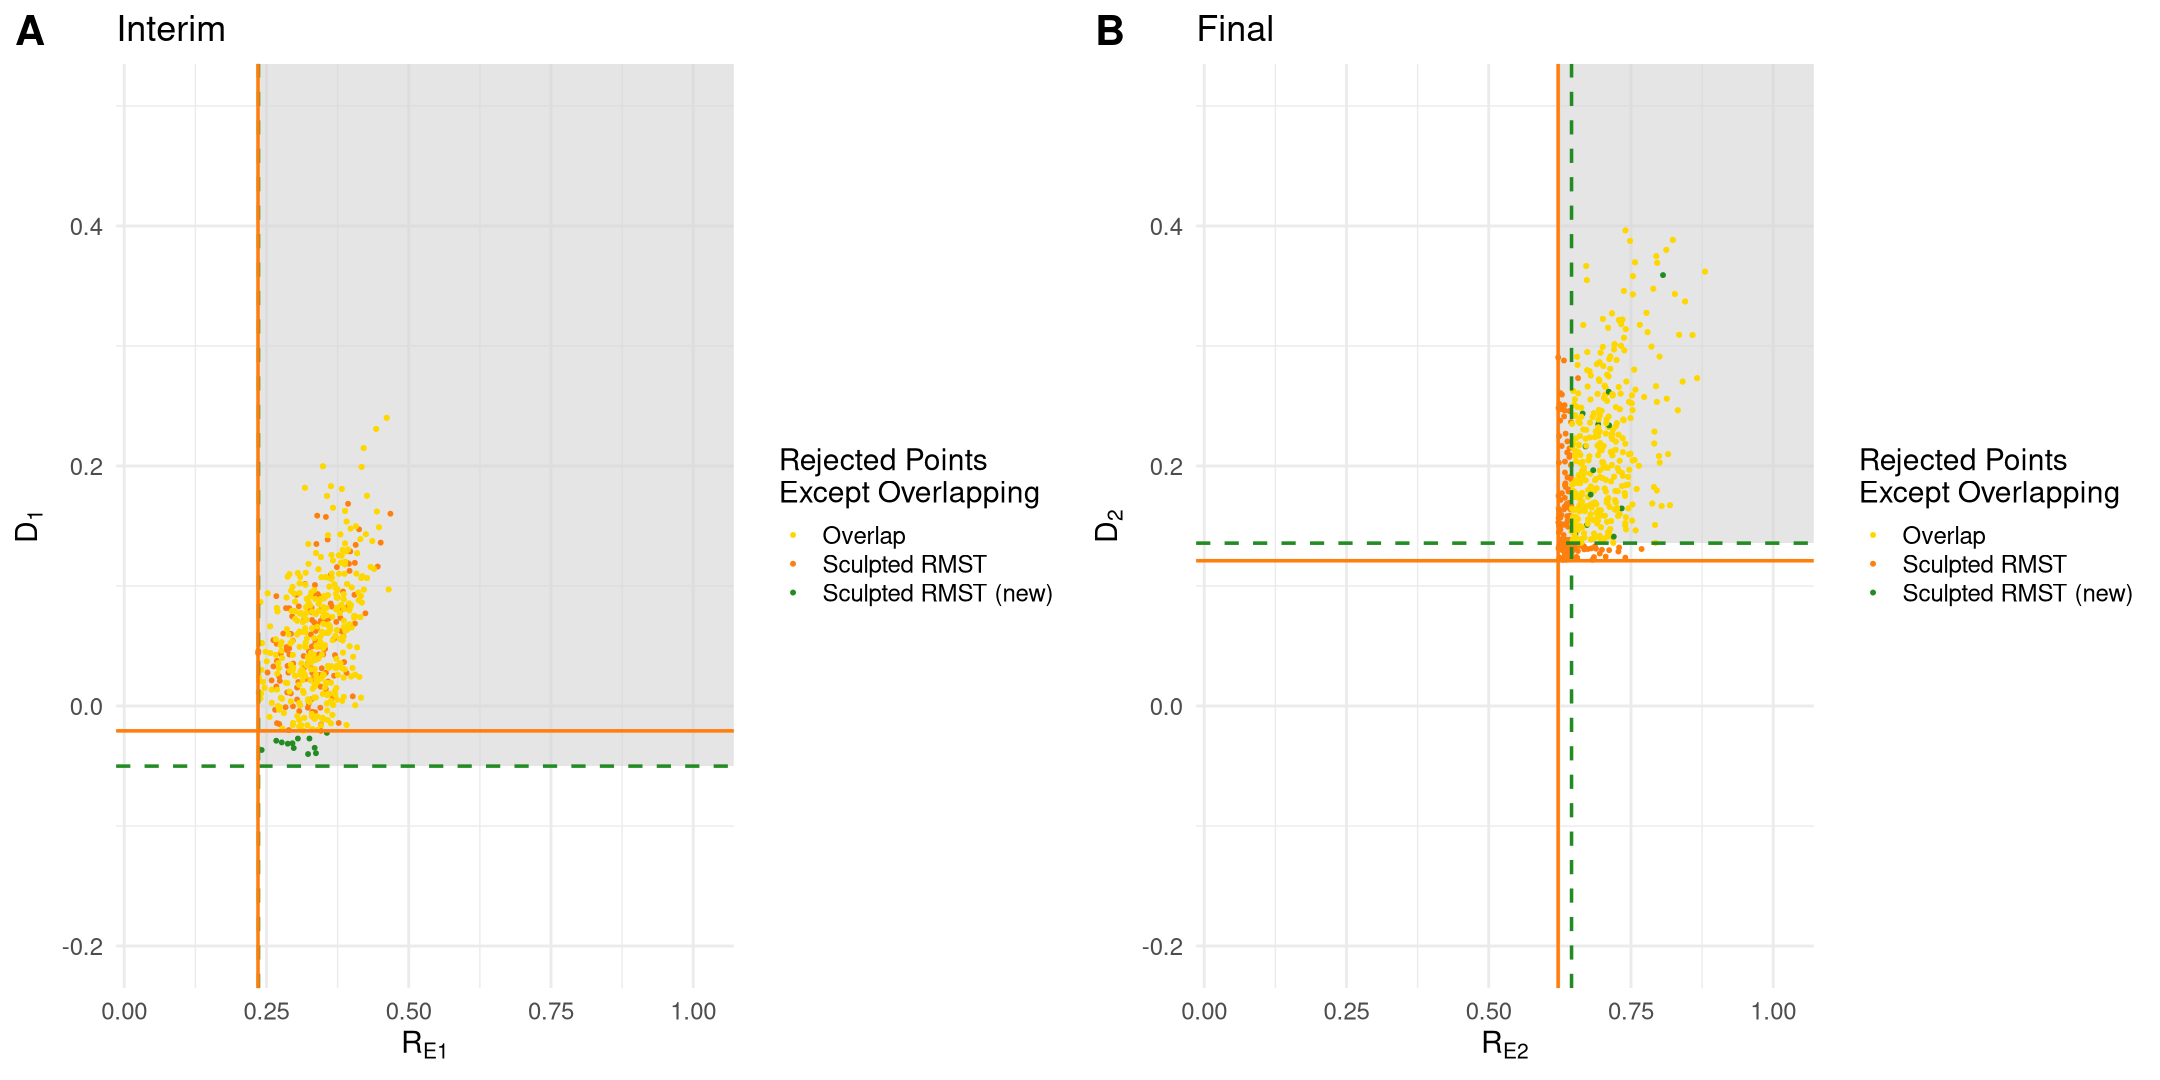

In [158]:
m1 <- as.numeric(best_our1$m1)
q1 <- as.numeric(best_our1$q1)
m2 <- as.numeric(best_our1$m2)
q2 <- as.numeric(best_our1$q2)
m1_rmst <- as.numeric(best_our2$m1)
q1_rmst <- as.numeric(best_our2$q1)
m2_rmst <- as.numeric(best_our2$m2)
q2_rmst <- as.numeric(best_our2$q2)


# data under H0 or H1
rmst_data_plot <- rbind(rmst_h0_int, rmst_h0_fin)
D1 <- rmst_data_plot[2,] - rmst_data_plot[1,]
R1 <- rmst_data_plot[2,]
D2 <- rmst_data_plot[4,] - rmst_data_plot[3,]
R2 <- rmst_data_plot[4,]
# Rejection region
Scu_R <- as.matrix(rmst_data_plot[, which(D1 > m1 & R1 > q1 & D2 > m2 & R2 > q2)])
Sim_R <- as.matrix(rmst_data_plot[, which(D1 > m1_rmst & R1 > q1_rmst & D2 > m2_rmst & R2 > q2_rmst)])

# Prepare data for the first scatterplot
data1 <- data.frame(
  x = c(Scu_R[2, ], Sim_R[2, ]),
  y = c(Scu_R[2, ] - Scu_R[1, ], Sim_R[2, ] - Sim_R[1, ]),
  group = rep(c("Sculpted RMST", "Sculpted RMST (new)"), times = c(ncol(Scu_R), ncol(Sim_R)))
)
data1 <- data1 %>%
  group_by(x, y) %>%
  mutate(overlap = ifelse(n() > 1, "Overlap", group)) %>%
  ungroup()

plot1 <- ggplot(data1, aes(x = x, y = y, color = overlap)) +
  annotate("rect", xmin = q1, xmax = Inf, ymin = m1_rmst, ymax = Inf, fill = "lightgrey", alpha = 0.6) +
  geom_point(size = 1) +
  scale_color_manual(values = c("Sculpted RMST (new)" = "#228B22", "Sculpted RMST" = "#ff7f0e", "Overlap" = "#FFD700")) +
  labs(title = "Interim", 
      x = expression(R[E1]), 
      y = expression(D[1]), 
      color = "Rejected Points\nExcept Overlapping") +
  theme_minimal(base_size = 18) +
  xlim(q1-0.2, q2+0.4) +
  ylim(-0.2, 0.5)+
  geom_hline(aes(yintercept = m1_rmst), color = "#228B22", linewidth = 1, linetype = "dashed", show.legend = FALSE) +
  geom_vline(aes(xintercept = q1_rmst), color = "#228B22", linewidth = 1, linetype = "dashed", show.legend = FALSE) +
  geom_hline(aes(yintercept = m1), color = "#ff7f0e", linewidth = 1, linetype = "solid", show.legend = FALSE) +
  geom_vline(aes(xintercept = q1), color = "#ff7f0e", linewidth = 1, linetype = "solid", show.legend = FALSE) 
  

data2 <- data.frame(
  x = c(Scu_R[4, ], Sim_R[4, ]),
  y = c(Scu_R[4, ] - Scu_R[3, ], Sim_R[4, ] - Sim_R[3, ]),
  group = rep(c("Sculpted RMST", "Sculpted RMST (new)"), times = c(ncol(Scu_R), ncol(Sim_R)))
)
data2 <- data2 %>%
  group_by(x, y) %>%
  mutate(overlap = ifelse(n() > 1, "Overlap", group)) %>%
  ungroup()

#data2 <- data2[data2$overlap != 'Overlap' , ]
plot2 <- ggplot(data2, aes(x = x, y = y, color = overlap)) +
  annotate("rect", xmin = q2, xmax = Inf, ymin = m2_rmst, ymax = Inf, fill = "lightgrey", alpha = 0.6) +
  geom_point(size = 1) +
  scale_color_manual(values = c("Sculpted RMST (new)" = "#228B22", "Sculpted RMST" = "#ff7f0e", "Overlap" = "#FFD700")) +
  labs(title = "Final", 
      x = expression(R[E2]), 
      y = expression(D[2]), 
      color = "Rejected Points\nExcept Overlapping") +
  theme_minimal(base_size = 18) +
  xlim(q1-0.2, q2+0.4) +
  ylim(-0.2, 0.5)+
  geom_hline(aes(yintercept = m2_rmst), color = "#228B22", linewidth = 1, linetype = "dashed", show.legend = FALSE) +
  geom_vline(aes(xintercept = q2_rmst), color = "#228B22", linewidth = 1, linetype = "dashed", show.legend = FALSE) +
  geom_hline(aes(yintercept = m2), color = "#ff7f0e", linewidth = 1, linetype = "solid", show.legend = FALSE) +
  geom_vline(aes(xintercept = q2), color = "#ff7f0e", linewidth = 1, linetype = "solid", show.legend = FALSE)


options(repr.plot.width = 18, repr.plot.height = 9)
combined_plot <- plot_grid(plot1, plot2, labels = c("A", "B"), label_size = 25, ncol = 2)
#ggsave("figures/rejection_plot.jpg", plot = combined_plot, width = 18, height = 9, dpi = 600)
combined_plot

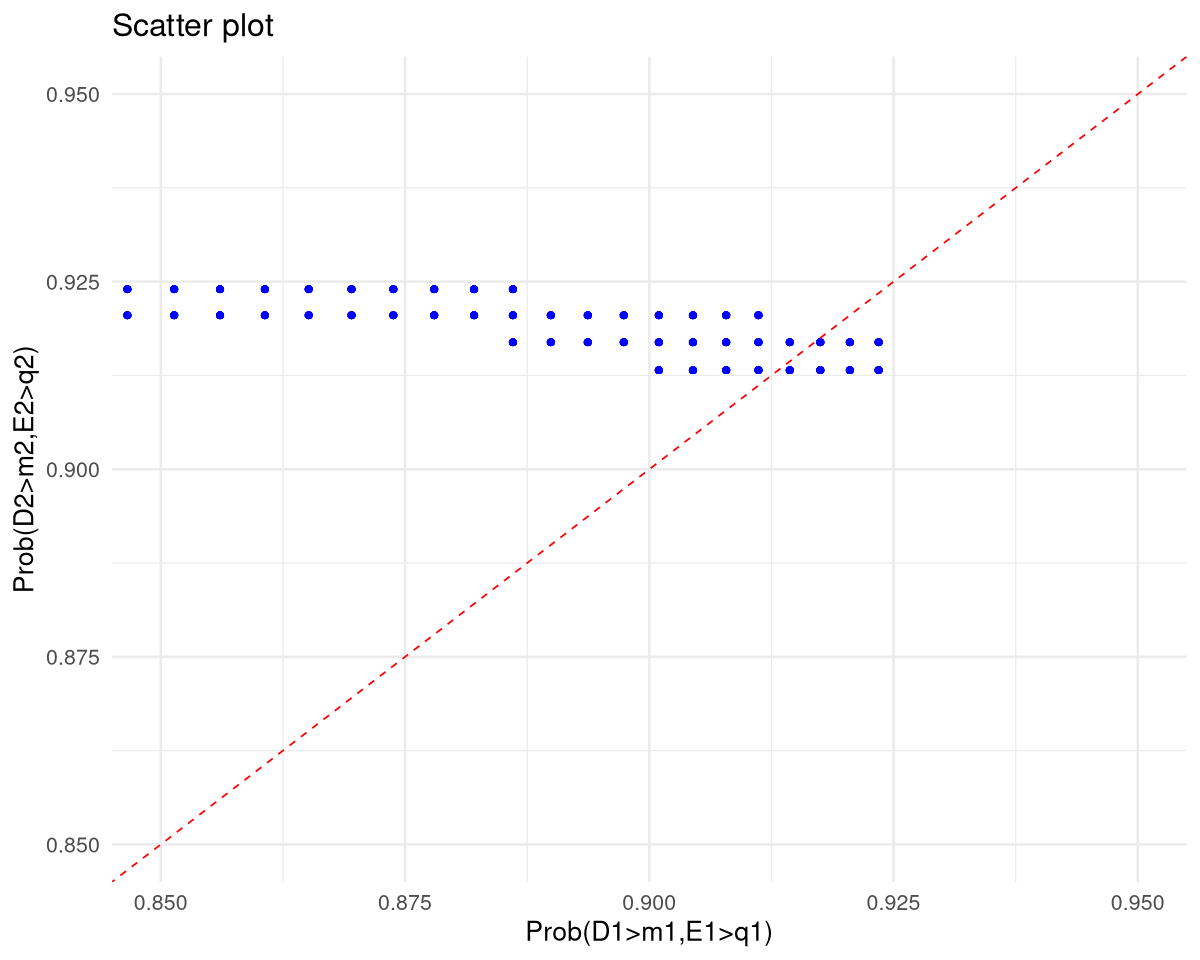

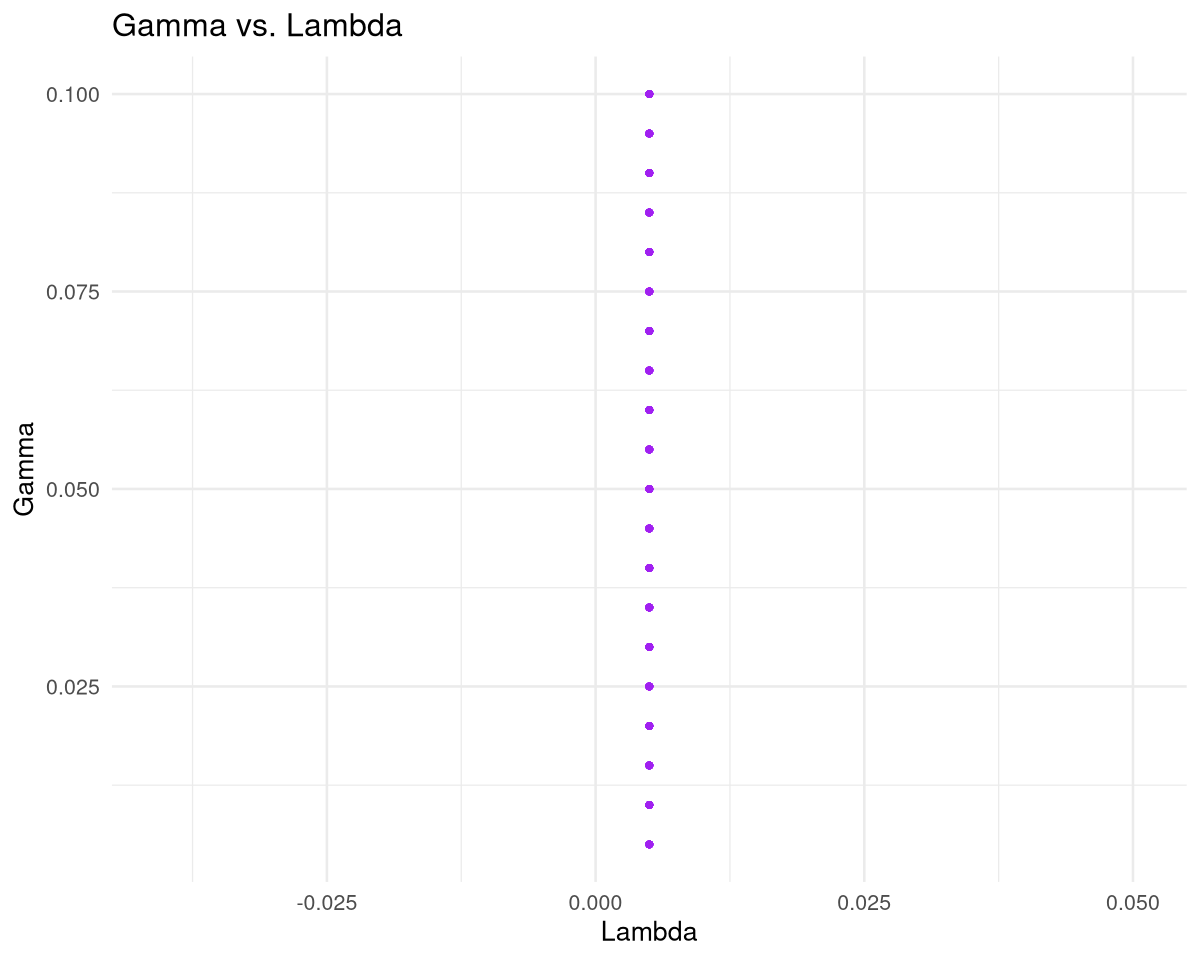

In [115]:
valid_res$pmv_int <- sapply(seq_len(nrow(valid_res)), function(i) {
    pmvnorm(
        lower = c(valid_res$m1[i], valid_res$q1[i]),
        upper = c(Inf, Inf),
        mean  = mu_cov_h1$mu[c(1,2)],
        sigma = mu_cov_h1$sigma[1:2, 1:2]
    )
})

valid_res$pmv_fin <- sapply(seq_len(nrow(valid_res)), function(i) {
    pmvnorm(
        lower = c(valid_res$m2[i], valid_res$q2[i]),
        upper = c(Inf, Inf),
        mean  = mu_cov_h1$mu[c(3,4)],
        sigma = mu_cov_h1$sigma[3:4, 3:4]
    )
})

df_scatter <- data.frame(
    pmv_int = valid_res$pmv_int,
    pmv_fin = valid_res$pmv_fin
)
ggplot(df_scatter, aes(x = pmv_int, y = pmv_fin)) +
    geom_point(alpha = 0.6, color = "blue") +
    geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") +
    labs(x = "Prob(D1>m1,E1>q1)", y = "Prob(D2>m2,E2>q2)", title = "Scatter plot") +
    theme_minimal(base_size = 16) +
    coord_cartesian(xlim = c(0.85, 0.95), ylim = c(0.85, 0.95))


ggplot(valid_res, aes(x = lambda, y = gamma)) +
    geom_point(alpha = 0.6, color = "purple") +
    labs(title = "Gamma vs. Lambda", x = "Lambda", y = "Gamma") +
    theme_minimal(base_size = 16)

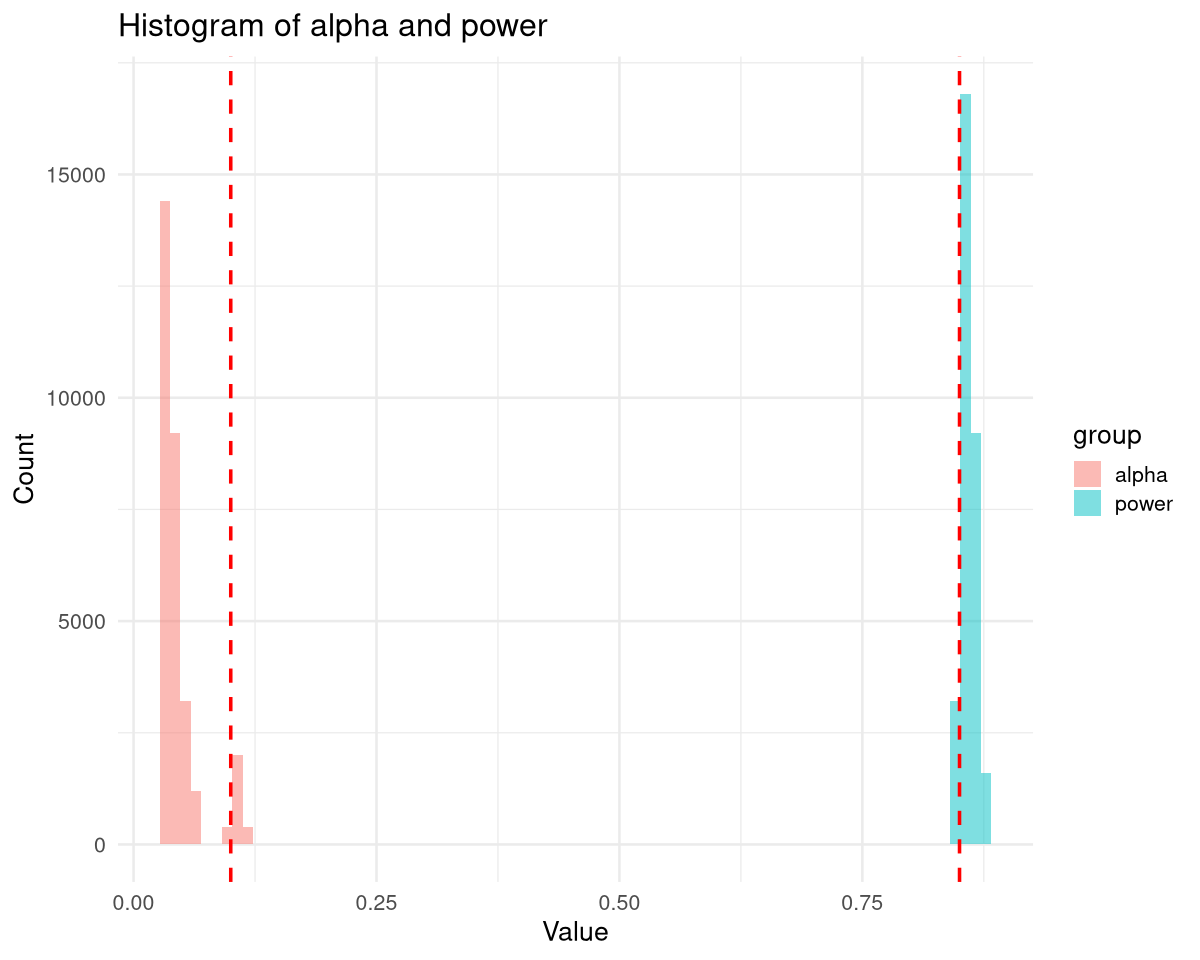

In [135]:
df_melt <- data.frame(
    value = c(crit_val_res$alpha, crit_val_res$power),
    group = rep(c("alpha", "power"), each = nrow(crit_val_res))
)
options(repr.plot.width = 10, repr.plot.height = 8)

ggplot(df_melt, aes(x = value, fill = group)) +
    geom_histogram(alpha = 0.5, position = "identity", bins = 80) +
    geom_vline(xintercept = 0.1, color = "red", linetype = "dashed", size = 1) +
    geom_vline(xintercept = 0.85, color = "red", linetype = "dashed", size = 1) +
    theme_minimal(base_size = 16) +
    labs(x = "Value", y = "Count", title = "Histogram of alpha and power")


In [117]:
best_rmst <- adp_grid_src(rmst_data = rmst_data, mu_cov_h0 = mu_cov_h0, mu_cov_h1 = mu_cov_h1, 
                int_n = interim * r, fin_n = 2 * n, alpha = alpha, power = power, sim_size = sim_size, method = 'Simple')

# best_our <- adp_grid_src(rmst_data = rmst_data, mu_cov_h0 = mu_cov_h0, mu_cov_h1 = mu_cov_h1, 
#                 int_n = interim * r, fin_n = 2 * n, alpha = alpha, power = power, sim_size = sim_size, method = 'Complex')
best_rmst <- best_rmst[which.min(best_rmst$power), ] 
# best_our

# Robustness
### When the real median survival time under $H_0$ is 10% longer than assumed value

In [118]:
m1 <- as.numeric(best_our1$m1[1])
q1 <- as.numeric(best_our1$q1[1])
m2 <- as.numeric(best_our1$m2[1])
q2 <- as.numeric(best_our1$q2[1])
m1_rmst <- best_rmst$m1[1]
m2_rmst <- best_rmst$m2[1]

# new median survival
lambda_H0 <- lambda_H0 / 1.1

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                cen_time = cen_time,arm = 0, interim = interim)    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, 
                            dist = 'pcw_exp', cen_time = cen_time, HR1 = HR1, HR2 = HR2, 
                            change_time = change_time, arm = 1, interim = interim)

rmst_h0_int <- RMST_sim_cal(n = n, data_E = data_E_H0[ , c(2,3,1)], data_C = data_C[ , c(2,3,1)],
                            tau = interim,sim_size = sim_size)
rmst_h0_fin <- RMST_sim_cal(n = n, data_E = data_E_H0[ , c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time, sim_size = sim_size)                        
rmst_h1_int <- RMST_sim_cal(n = n, data_E = data_E_H1[ , c(2,3,1)], data_C = data_C[ , c(2,3,1)],
                            tau = interim,sim_size = sim_size)
rmst_h1_fin <- RMST_sim_cal(n = n, data_E = data_E_H1[ , c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time, sim_size = sim_size)

cat('The power and type I error of our method under new median survival are: \n')
sum((rmst_h1_int[2, ] - rmst_h1_int[1, ] > m1) & (rmst_h1_int[2, ] > q1) &
    (rmst_h1_fin[2, ] - rmst_h1_fin[1, ] > m2) & (rmst_h1_fin[2, ] > q2)) / sim_size
sum((rmst_h0_int[2, ] - rmst_h0_int[1, ] > m1) & (rmst_h0_int[2, ] > q1) &
    (rmst_h0_fin[2, ] - rmst_h0_fin[1, ] > m2) & (rmst_h0_fin[2, ] > q2)) / sim_size
cat('The power and type I error of Simple under new median survival are: \n')
sum((rmst_h1_int[2, ] - rmst_h1_int[1, ] > m1_rmst) &
    (rmst_h1_fin[2, ] - rmst_h1_fin[1, ] > m2_rmst) ) / sim_size
sum((rmst_h0_int[2, ] - rmst_h0_int[1, ] > m1_rmst) &
    (rmst_h0_fin[2, ] - rmst_h0_fin[1, ] > m2_rmst) ) / sim_size  

The power and type I error of our method under new median survival are: 


[1] 0.8668

[1] 0.1574

The power and type I error of Simple under new median survival are: 


[1] 0.8774

[1] 0.138

In [ ]:
lambda_H1 <- 0.9  #0.84
diff_HR_robust <- foreach(lambda_H0 = seq(1.4, 1.65, by = 0.05), .combine = rbind) %dopar%
{
    data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                cen_time = cen_time,arm = 0, interim = interim)    
    data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)
    data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, 
                            dist = 'pcw_exp', cen_time = cen_time, HR1 = HR1, HR2 = HR2, 
                            change_time = change_time, arm = 1, interim = interim)

    rmst_h0_int <- RMST_sim_cal(n = n, data_E = data_E_H0[ , c(2,3,1)], data_C = data_C[ , c(2,3,1)],
                            tau = interim,sim_size = sim_size)
    rmst_h0_fin <- RMST_sim_cal(n = n, data_E = data_E_H0[ , c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time, sim_size = sim_size)                        
    rmst_h1_int <- RMST_sim_cal(n = n, data_E = data_E_H1[ , c(2,3,1)], data_C = data_C[ , c(2,3,1)],
                            tau = interim,sim_size = sim_size)
    rmst_h1_fin <- RMST_sim_cal(n = n, data_E = data_E_H1[ , c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time, sim_size = sim_size)

    z_stats_h0_int <- log_rank_sim(data_C = data_C[ , c(2,3,1)], data_E = data_E_H0[ , c(2,3,1)],
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
    z_stats_h1_int <- log_rank_sim(data_C = data_C[ , c(2,3,1)], data_E = data_E_H1[ , c(2,3,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
    z_stats_h0_fin <- log_rank_sim(data_C =  data_C[ , c(4,5,1)], data_E = data_E_H0[ , c(4,5,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
    z_stats_h1_fin <- log_rank_sim(data_C =  data_C[ , c(4,5,1)], data_E = data_E_H1[ , c(4,5,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats

    a_lr <- sum(z_stats_h0_int > m1_lr & z_stats_h0_fin > m2_lr) / sim_size
    power_lr <- sum(z_stats_h1_int > m1_lr & z_stats_h1_fin > m2_lr) / sim_size
    pet0_lr <- sum(z_stats_h0_int <= m1_lr) / sim_size
    pet1_lr <- sum(z_stats_h1_int <= m1_lr) / sim_size

    a_rmst <- sum((rmst_h0_int[2, ] - rmst_h0_int[1, ] > m1_rmst) &
                    (rmst_h0_fin[2, ] - rmst_h0_fin[1, ] > m2_rmst)) / sim_size
    power_rmst <- sum((rmst_h1_int[2, ] - rmst_h1_int[1, ] > m1_rmst) &
                    (rmst_h1_fin[2, ] - rmst_h1_fin[1, ] > m2_rmst)) / sim_size
    pet0_rmst <- sum(rmst_h0_int[2, ] - rmst_h0_int[1, ] <= m1_rmst) / sim_size
    pet1_rmst <- sum(rmst_h1_int[2, ] - rmst_h1_int[1, ] <= m1_rmst) / sim_size

    a_our <- sum((rmst_h0_int[2, ] - rmst_h0_int[1, ] > m1) & (rmst_h0_int[2, ] > q1) &
                (rmst_h0_fin[2, ] - rmst_h0_fin[1, ] > m2) & (rmst_h0_fin[2, ] > q2)) / sim_size
    power_our <- sum((rmst_h1_int[2, ] - rmst_h1_int[1, ] > m1) & (rmst_h1_int[2, ] > q1) &
                    (rmst_h1_fin[2, ] - rmst_h1_fin[1, ] > m2) & (rmst_h1_fin[2, ] > q2)) / sim_size
    pet0_our <- sum((rmst_h0_int[2, ] - rmst_h0_int[1, ] <= m1) | (rmst_h0_int[2, ] <= q1)) / sim_size
    pet1_our <- sum((rmst_h1_int[2, ] - rmst_h1_int[1, ] <= m1) | (rmst_h1_int[2, ] <= q1)) / sim_size
    median_sur <- round(log(2) / lambda_H0 * 12, 2)
    
    return(c( median_sur, a_lr, a_rmst, a_our, power_lr, power_rmst, power_our, 
              pet0_lr, pet0_rmst, pet0_our, pet1_lr, pet1_rmst, pet1_our ))
}

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 8)
data <- diff_HR_robust
    color_palette <- c("ScuRMST_power" = "darkred", "ScuRMST_alpha" = "darkred", 
                      "LR_power" = "lightgreen", "LR_alpha" = "lightgreen",
                      "SimRMST_power" = "blue", "SimRMST_alpha" = "blue",
                      "ScuRMST_PET0" = "darkred", "ScuRMST_PET1" = "darkred", 
                      "LR_PET0" = "lightgreen", "LR_PET1" = "lightgreen",
                      "SimRMST_PET0" = "blue", "SimRMST_PET1" = "blue")

    a_power_delta <- data.frame(data[, c(1,2,3,4,5,6,7)])
    colnames(a_power_delta) <- c('lambda_1','LR_alpha','SimRMST_alpha','ScuRMST_alpha',
                          'LR_power', 'SimRMST_power','ScuRMST_power')
    a_power_long <- a_power_delta %>%
        pivot_longer(cols = -!!sym('lambda_1'), names_to = "variable", values_to = "value")%>%
        mutate(linetype_group = ifelse(variable %in% 
            c("LR_alpha", "SimRMST_alpha", "ScuRMST_alpha"), "Alpha", "Power"))
    a_power_long <- a_power_long %>% filter(value != 0)   # 0 means could not find critical values

p_HR2 <- ggplot(a_power_long, aes(x = !!sym('lambda_1'), y = value, 
        color = variable, linetype = linetype_group)) +
    geom_point(size = 3) +
    geom_line(linewidth = 1) +
    geom_vline(xintercept = round(log(2)/1.53*12, 2), color = "red", linetype = "dashed", linewidth = 1) +
    scale_linetype_manual(values = c("Alpha" = "dotted", "Power" = "solid")) +
    labs( linetype = "Line Type", color = "Variable") +
    scale_y_continuous(breaks = c(0, 0.05, 0.25, 0.5, 0.75, 0.8, 0.95, 1), limits = c(0, 1)) +
    scale_x_continuous(limits = c(5, 6)) +
    scale_color_manual(values = color_palette) +
    labs(x = expression(paste("Assumed median survival time (months) of two groups under ",H[0])), y = "Value", color = "Variable",
      title = expression(paste("Precise hazard value ",lambda[1]," under ", H[1] ))) +
    theme_minimal(base_size = 18) + 
    theme(plot.title = element_text(hjust = 0.5),
          plot.background = element_rect(fill = "white", color = NA),
          plot.margin = unit(c(1, 1, 1, 1), "cm")) +
    guides(linetype = guide_legend(override.aes = list(color = "black")),
        color = guide_legend(override.aes = list(linetype = "solid")))
p_HR2

In [80]:
readRDS("tem_result_scu.rds")
readRDS("tem_result_sim.rds")

PET0,PET1,alpha,power,PET,EN0,EN1,EN,interim_n,N,Method
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<dbl>,<chr>
0,0,0,0,0,NA,NA,NA,NA,38,scu_rmst
0,0,0,0,0,NA,NA,NA,NA,42,scu_rmst
0,0,0,0,0,NA,NA,NA,NA,46,scu_rmst


,PET0,PET1,alpha,power,PET,EN0,EN1,EN,interim_n,N,Method
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,0.0000,0.0000,0.0000,0.0000,0.0000,NA,NA,NA,NA,40,sim_rmst
2,0.0000,0.0000,0.0000,0.0000,0.0000,NA,NA,NA,NA,44,sim_rmst
5254,0.2062,0.0316,0.0984,0.8502,0.1189,43.29864,47.27952,45.28908,26,48,sim_rmst
5067,0.3282,0.0654,0.0966,0.8506,0.1968,43.72936,50.35192,47.04064,27,52,sim_rmst
4775,0.4428,0.1032,0.0996,0.8528,0.2730,44.66432,53.35808,49.01120,31,56,sim_rmst


----